<a href="https://colab.research.google.com/github/vicentcamison/idal_ia3/blob/main/2%20Aprendizaje%20profundo%20(I)/Sesion%201/2_custom_training_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Entrenamiento personalizado
Esta guía usa *machine learning* para predecir la progresión de la diabetes después un año. Utiliza TensorFlow para:
1. Construir un modelo
2. Entrenar este modelo en datos de ejemplo
3. Usa el modelo para hacer predicciones en datos desconocidos

Este tutorial está estructurado de la siguiente manera:

1. Importación y análisis del conjunto de datos.
2. Selección del tipo de modelo.
3. Entrenamiento del modelo.
4. Evaluación de la efectividad del modelo.
5. Uso del modelo entrenado para hacer predicciones.

## Preparación del programa

### Configuración de los *imports*

Importa TensorFlow y los demás módulos de Python necesarios. De forma predeterminada, TensorFlow usa una *eager execution* para evaluar las operaciones de inmediato, y muestra valores concretos en lugar de crear un gráfico computacional que se ejecuta más tarde. Si estás acostumbrado la consola interactiva de python , esto te resultará familiar.

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn import datasets
from sklearn.model_selection import train_test_split
from math import ceil
import numpy as np

In [ ]:
print("TensorFlow version: {}".format(tf.__version__))
print("Eager execution: {}".format(tf.executing_eagerly()))

TensorFlow version: 2.3.0
Eager execution: True


## Problema de regresión *Diabetes*

Este conjunto de datos contiene 10 variables descriptivas edad, sexo, índice de masa corporal, presión sanguínea promedio, y seis mediciones de suero sanguíneo tomadas para cada uno de los 442 pacientes con diabetes. Además, contiene la variable de interés a predecir, una medida cuantitavita de la progresíon de la enferemedad un año después del inicio.

### Características del conjunto de datos


*   Número de instancias: 442
*   Número de atributos: Las 10 primeras columnas son valores predictivos numéricos

*   Variable objetivo: La columna 11 es una medida cuantitativa de la progresión de la enfermedad después de un año
*   Elemento de lista

### Información de los atributos:

       - age: edad en años
       - sex
       - bmi: índice de masa corporal
       - bp: presión arterial media
       - s1 tc, células T (un tipo de glóbulos blancos)
       - s2 ldl, lipoproteínas de baja densidad
       - s3 hdl, lipoproteínas de alta densidad
       - s4 tch, hormona estimulante de la tiroides
       - s5 ltg, lamotrigina
       - glu s6, nivel de azúcar en sangre


Nota: Cada una de estas 10 variables se ha centrado en la media y se ha escalado por la desviación estándar.




## Importación y preparación del conjunto de datos


### Carga del conjunto de datos

In [ ]:
diabetes = datasets.load_diabetes()
features, labels = diabetes.data, diabetes.target

### Partición del conjunto de datos en Entrenamiento, Validación y Test

A continuación vamos a separar nuestro conjunto de datos en 3 conjuntos distinitos (entrenamiento, validadción y test). Para ello utiliza el método `tain_test_split` de la librería *sklearn*. Para garantizar aleatoriedad en las particiones, mezcla de manera aleatoria las muestras. Para llevar a cabo las particiones, mantén un 70% de los datos para el conjunto de entrenamiento y un 15% tanto para el de validación como para el de test

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(features,
                                                    labels,
                                                    test_size=0.30,
                                                    random_state=42,
                                                    shuffle=True,
                                                    stratify=None)

x_train, x_val, y_train, y_val = train_test_split(x_train,
                                                  y_train,
                                                  test_size=0.50,
                                                  random_state=42,
                                                  shuffle=True,
                                                  stratify=None)

A continuación vamos a estandarizar los datos. Como ya se ha comentado anteriormente, no sería necesarario ya que los datos ya vienen estandarizados al cargarlos. No obstante, a modo de ejercicio, estandariza los datos manualmente, sin ayuda de librerías externas siguiendo la siguiente fórmula:

$$x_{norm}=\frac{x-\mu}{\sigma}$$

Dónde $\mu$ es la media y $\sigma$ las desviación estandar.

In [ ]:
x_train_norm = (x_train-np.mean(x_train, 0))/np.std(x_train)
x_val_norm = (x_val-np.mean(x_val, 0))/np.std(x_val)
x_test_norm = (x_test-np.mean(x_test, 0))/np.std(x_test)

y_train_norm = (y_train-np.mean(y_train, 0))/np.std(y_train)
y_val_norm = (y_val-np.mean(y_val, 0))/np.std(y_val)
y_test_norm = (y_test-np.mean(y_test, 0))/np.std(y_test)

A caontinuación, utiliza el método `tf.data.Dataset.from_tensor_slices` para convertir tus datos a tensores

In [ ]:

train_dataset = tf.data.Dataset.from_tensor_slices((x_train_norm, y_train_norm))
val_dataset = tf.data.Dataset.from_tensor_slices((x_val_norm, y_val_norm))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test_norm, y_test_norm))

El objeto que te devuelve para cada uno de tus conjuntos de datos es de tipo `TensorSliceDataset`. Éste, tiene métodos interesantes para poder generar *batches* para entrenar la red neuronal. Echa un vistazo a la [API](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) para ver los métdos que pueden resultar útiles. Te diré como pista que queremos "barajar" los datos después de cada iteración. Además queremos dividir los datos en *batches*, y mantener siempre el mismo tamaño de *batch* (incluso el último, aunque la longitud de nuestros datos entre la longitud del *batch* no sea un número entero). Además, pégale un vistazo a la opicón *cache*. Para este ejercicio puede no ser necesaria pero para otra clase de problemas puede ser muy útil.

In [ ]:
BATCH_SIZE = 32

train_dataset = (train_dataset.cache()
                 .shuffle(len(x_train), reshuffle_each_iteration=True)
                 .repeat()
                 .batch(BATCH_SIZE)
                 .take(ceil(len(x_train) / BATCH_SIZE))
                 )

val_dataset = (val_dataset.cache()
               .shuffle(len(x_val), reshuffle_each_iteration=True)
               .repeat()
               .batch(BATCH_SIZE)
               .take(ceil(len(x_val) / BATCH_SIZE))
               )

## Creación y entrenamiento del Modelo Neuronal


En este apartado vamos a crear y entrenar un Perceptron Multicapa. A continuación crea dicho modelo neuronal utilizando *layers* de *Keras*. Puedes utilizar tanto la api secuencial como la funcional. Cre un modelo con una capa oculta. No te preocupes por el número de neurones, vamos a ir jugando para ver como varían los resultados en función de este parámetro

In [ ]:
DATASET_COLUMNS = diabetes.data.shape[1]

model = tf.keras.Sequential([
    tf.keras.layers.Dense(300, activation=tf.nn.relu, input_shape=(DATASET_COLUMNS,)),  # input shape required
    tf.keras.layers.Dense(300, activation=tf.nn.relu),
    tf.keras.layers.Dense(1, activation='linear')
])


A continuación vamos a crear nuestra función de pérdidas ¿Qué tipo de loss utilizarías para este problema? Utiliza las classe disponibles en la api de *keras* y después crea una función que devuelva el *loss* teniendo como parámetros de entrada los datos de entrada a la red y la variable de salida conocida. Ten en cuento que para calcular el *loss*, deberás calcular la salida del modelo para dicha entrada

In [ ]:
loss_object = tf.keras.losses.MeanSquaredError()


In [ ]:
def loss(x, y):
    # training=training is needed only if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    y_ = model(x, training=True)
    return loss_object(y_true=y, y_pred=y_)

A continuación vamos a crear los pasos de entrenamiento y validación de manera manual. El proceso para entrenar y validar una red es el siguiente. Se coje un *batch* del conjunto de datos de entrenamiento, se entrena la red y se calcula el *loss*. Este *loss* se va acumulando hasta que acaba la época para tener una metrica que varía en cada época. Con el conjunto de validación se hace lo mismo, solo que no se entrea (no se actualizan los pesos de la red) con ellos, solamente calculamos el error en este conjunto. Es decir, estos datos se utilizan para ver como evoluciona el error del la red durante el entrenamiento para datos que nunca ha visto antes. Por ello, en el paso de validación no se ha de actualiar los pesos, es decir, solamente se hará el *forward pass* y se evitará el *backward pass*.

<br><rb>
Tal y como se ha comentado anteriormente, en el proceso de entrenamiento se actualizan los pesos, por lo que se han de calcular los gradientes. [Aquí](https://www.tensorflow.org/api_docs/python/tf/GradientTape) tienes ayuda de como calcular los gradientes:


In [ ]:
def train_step(inputs, labels):
    with tf.GradientTape() as tape:
        loss_value = loss(inputs, labels)
        gradients = tape.gradient(loss_value, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss_value

A continuación calcularemos el `val_step`, este es más fácil todavía, recuerda que en este paso no hay cálulo de gradientes ni retropropagación de los mismos a través de la red:

In [ ]:
def val_step(inputs, labels):
    loss_value = loss(inputs, labels)
    return loss_value

A continuación crearemos el optimizador. Utiliza el *Stocasthic Gradient Descent* disponible en la librería de *Keras*.

In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)


A continuación, crea el proceso de entrenamiento. El proceso es similar al del ejercicio anterior, dónde se crearon *batches* de nuestro conjunto de datos para ir pasándoselos a la red por lotes. Ten en cuenta que en este caso, los lotes están creados internamente en objecto de datos de tipo `TensorSliceDataset` que has creado. Este objeto es un iterable, así que puedes utilizarlo en un bucle `for` para que te vaya devolviendo *batches*. Por lo tanto, necesitarás 2 bucles `for`. El primero iterará sobre un número de iteraciones (épocas), y el segundo sobre los *batches*. Se pasará cada *batch* a la red para realizar el entrenamiento (con el método que has creado `train_step`). Además necesitas crear las métricas a utilizar. Despúes de pasar por la red cada *batch* calcularemos el *loss* promedio. Para ello utiliza `tf.keras.metrics.Mean()`. Has de realizar el mismo proceso pero utilizando el método `val_step`.

<br><rb>

Imprime los resultados por pantalla (cada 5 épocas)


In [ ]:
train_loss_results = []
val_loss_results = []

num_epochs = 200

for epoch in range(num_epochs):
    epoch_train_loss_avg = tf.keras.metrics.Mean()
    epoch_val_loss_avg = tf.keras.metrics.Mean()

    # Training loop - using batches of 32
    for n_sample, (x, y) in enumerate(train_dataset):   # Optimize the model
        train_loss = train_step(x, y)

        # Track progress
        epoch_train_loss_avg.update_state(train_loss)  # Add current batch loss

    for x, y in val_dataset:
        val_loss = val_step(x, y)
        epoch_val_loss_avg.update_state(val_loss)  # Add current batch loss

    # End epoch
    train_loss_results.append(epoch_train_loss_avg.result())
    val_loss_results.append(epoch_val_loss_avg.result())

    if epoch % 5 == 0:
        print("Epoch {:03d}: Training Loss: {:.3f}, Val Loss: {:.3f}, ".format(epoch,
                                                                               epoch_train_loss_avg.result(),
                                                                               epoch_val_loss_avg.result(),
                                                                               )

              )


Epoch 000: Training Loss: 0.897, Val Loss: 0.835, 
Epoch 005: Training Loss: 0.535, Val Loss: 0.555, 
Epoch 010: Training Loss: 0.474, Val Loss: 0.539, 
Epoch 015: Training Loss: 0.441, Val Loss: 0.526, 
Epoch 020: Training Loss: 0.431, Val Loss: 0.516, 
Epoch 025: Training Loss: 0.398, Val Loss: 0.503, 
Epoch 030: Training Loss: 0.393, Val Loss: 0.507, 
Epoch 035: Training Loss: 0.380, Val Loss: 0.542, 
Epoch 040: Training Loss: 0.366, Val Loss: 0.535, 
Epoch 045: Training Loss: 0.352, Val Loss: 0.534, 
Epoch 050: Training Loss: 0.345, Val Loss: 0.542, 
Epoch 055: Training Loss: 0.334, Val Loss: 0.534, 
Epoch 060: Training Loss: 0.318, Val Loss: 0.552, 
Epoch 065: Training Loss: 0.319, Val Loss: 0.550, 
Epoch 070: Training Loss: 0.305, Val Loss: 0.562, 
Epoch 075: Training Loss: 0.297, Val Loss: 0.559, 
Epoch 080: Training Loss: 0.299, Val Loss: 0.558, 
Epoch 085: Training Loss: 0.293, Val Loss: 0.576, 
Epoch 090: Training Loss: 0.274, Val Loss: 0.584, 
Epoch 095: Training Loss: 0.272

Dibuja el error de entrenamiento y el de validación en una figura.

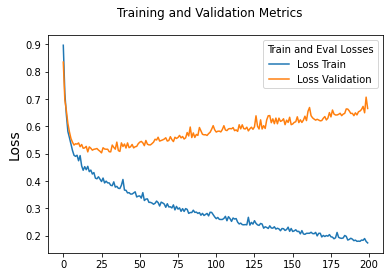

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
fig.suptitle('Training and Validation Metrics')
ax.set_ylabel("Loss", fontsize=14)
ax.plot(train_loss_results, label='Loss Train')
ax.plot(val_loss_results, label='Loss Validation')
ax.legend(title='Train and Eval Losses')
plt.show()